In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [43]:
links = pd.read_csv('../../data/links.csv')
movies = pd.read_csv('../../data/movies.csv')
ratings = pd.read_csv('../../data/ratings.csv')
tags = pd.read_csv('../../data/tags.csv')

In [44]:
print(f'Number of movies: {movies["title"].nunique()}')
print(f'Number of users: {ratings["userId"].nunique()}')
print(f'Number of ratings: {len(ratings)}')
print(f'Number of tags: {len(tags)}')
print(f'Average ratings per user: {len(ratings)/ratings["userId"].nunique():.2f}')
print(f'Average ratings per movie: {len(ratings)/movies["movieId"].nunique():.2f}')

Number of movies: 9737
Number of users: 610
Number of ratings: 100836
Number of tags: 3683
Average ratings per user: 165.30
Average ratings per movie: 10.35


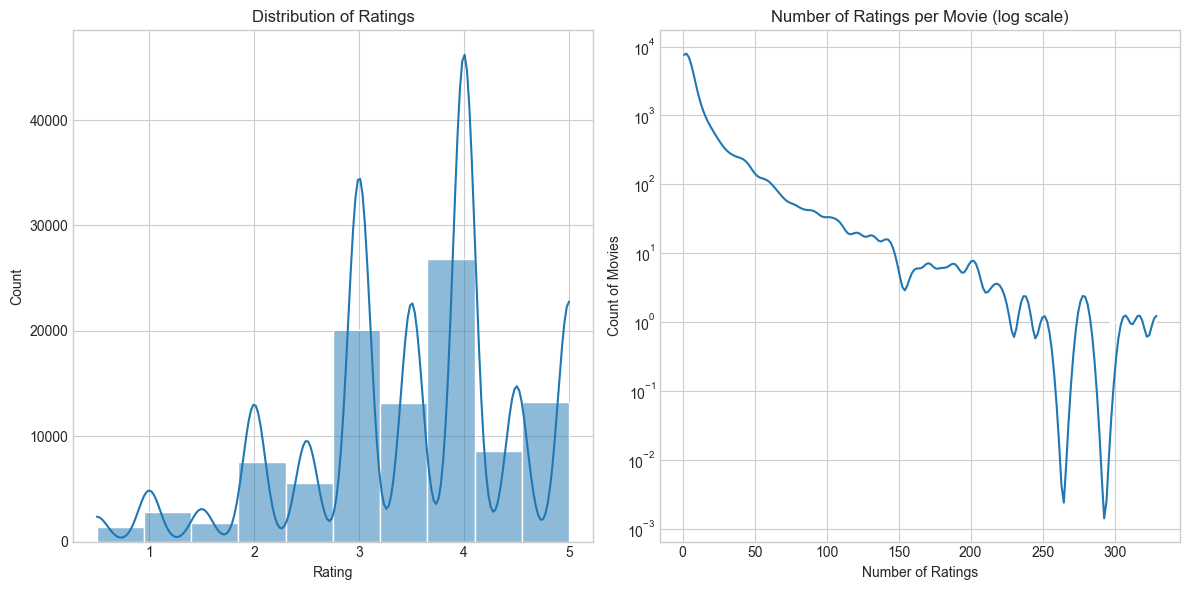

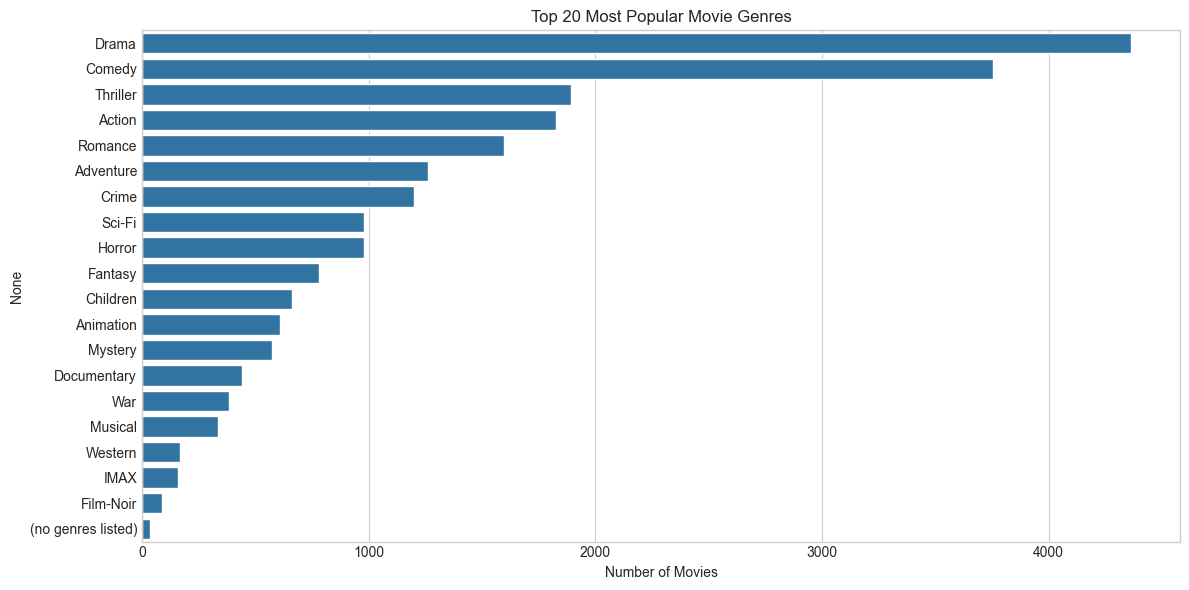

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
movie_count = ratings.groupby('movieId').size()
sns.histplot(movie_count, bins=30, kde=True, log_scale=(False, True))
plt.title('Number of Ratings per Movie (log scale)')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.tight_layout()
plt.show()

all_genres = []
for genres in movies['genres'].str.split('|'):
    all_genres.extend(genres)

genre_counts = pd.Series(all_genres).value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Top 20 Most Popular Movie Genres')
plt.xlabel('Number of Movies')
plt.tight_layout()
plt.show()

In [46]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [47]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [48]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [49]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [50]:
movies_ratings = movies.merge(ratings, how='left', on='movieId')
movies_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


In [51]:
with_tags = movies_ratings.merge(tags, how='left', on=['movieId', 'userId'])
with_tags.head()

,movieId,title,genres,userId,rating,timestamp_x,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08,NaN,NaN
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08,NaN,NaN
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09,NaN,NaN
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09,NaN,NaN
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09,NaN,NaN


In [52]:
with_tags['tag'].count()

np.int64(3476)

In [61]:
def ids_encoder(ratings):
    df = ratings.copy()
    # create users and items encoders
    uencoder = LabelEncoder().fit(df['userId'])
    iencoder = LabelEncoder().fit(df['movieId'])
    # fit users and items ids to the corresponding encoder and transform
    df['uid'] = uencoder.transform(df['userId'])
    df['iid'] = iencoder.transform(df['movieId'])

    return df, uencoder, iencoder

ratings, uencoder, iencoder = ids_encoder(ratings)

def build_rating_matrix(df):
    n_u = df['uid'].nunique()
    n_i = df['iid'].nunique()
    rows = df['uid'].values
    cols = df['iid'].values
    data = df['rating'].values.astype(np.float32)
    return csr_matrix((data, (rows, cols)), shape=(n_u, n_i))

R = build_rating_matrix(ratings)
print(f"Rating matrix shape: {R.shape}")
print(f"Sparsity: {R.nnz / (R.shape[0] * R.shape[1]):.4f} ({R.nnz} non-zero elements)")

Rating matrix shape: (610, 9724)
Sparsity: 0.0170 (100836 non-zero elements)


# Non-Personalised Recommender Systems
First, we compute the mean rating of each user and the normalized ratings for each item. The DataFrame mean contains mean rating for each user. With the mean rating of each user, we can add an extra column norm_rating to the ratings's DataFrame which can be accessed to make predictions.

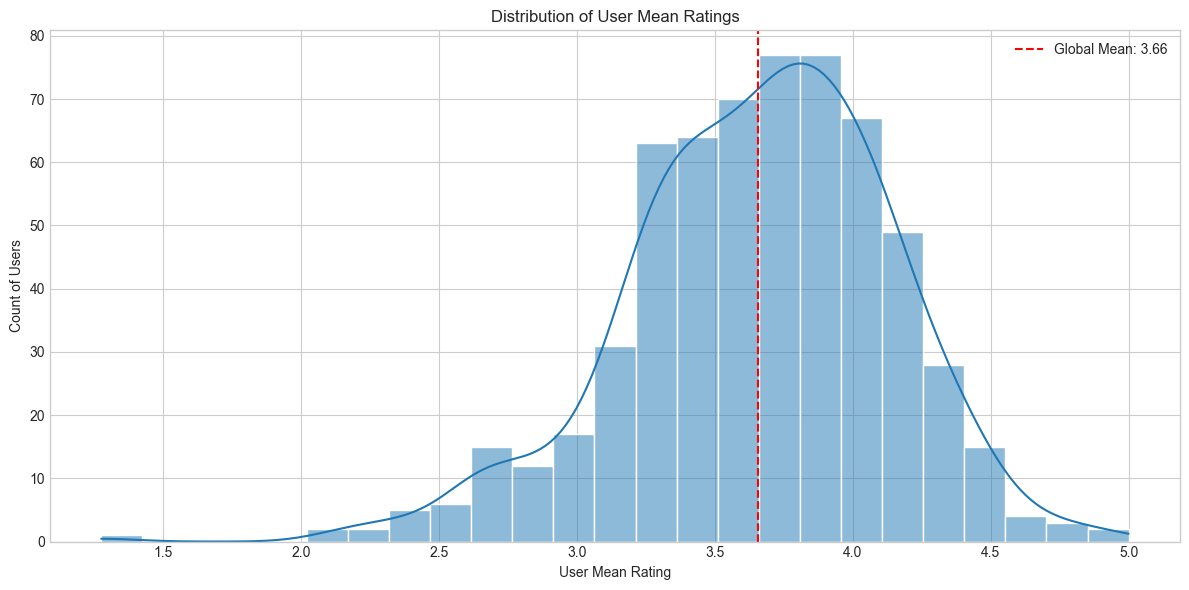

        userId  movieId  rating   timestamp  rating_mean  norm_rating
0            0        0     4.0   964982703     4.366379    -0.366379
1            0        2     4.0   964981247     4.366379    -0.366379
2            0        5     4.0   964982224     4.366379    -0.366379
3            0       43     5.0   964983815     4.366379     0.633621
4            0       46     5.0   964982931     4.366379     0.633621
...        ...      ...     ...         ...          ...          ...
100831     609     9416     4.0  1493848402     3.688556     0.311444
100832     609     9443     5.0  1493850091     3.688556     1.311444
100833     609     9444     5.0  1494273047     3.688556     1.311444
100834     609     9445     5.0  1493846352     3.688556     1.311444
100835     609     9485     3.0  1493846415     3.688556    -0.688556

[100836 rows x 6 columns]
       userId  movieId  rating   timestamp
568         5       10     4.0   845553489
1028        7       10     4.0   839463806
5033

In [59]:
# mean ratings for each user
user_means = ratings.groupby('userId')['rating'].mean()
mean_ratings = pd.merge(ratings, user_means, suffixes=('','_mean'), on='userId')
# normalized ratings for each items
mean_ratings['norm_rating'] = mean_ratings['rating'] - mean_ratings['rating_mean']

plt.figure(figsize=(12, 6))
sns.histplot(user_means, kde=True)
plt.axvline(user_means.mean(), color='red',
            linestyle='--', 
            label=f'Global Mean: {user_means.mean():.2f}')
plt.title('Distribution of User Mean Ratings')
plt.xlabel('User Mean Rating')
plt.ylabel('Count of Users')
plt.legend()
plt.tight_layout()
plt.show()

print(mean_ratings)
print(ratings[ratings['movieId'] == 10])
print(mean_ratings[mean_ratings['movieId'] == 10])



To consider deviation of user ratings, (How much does a user like an item compared to how much he normally likes an item?), we normalize the ratings of a particular user against a particular item by considering the average rating of that user across all items. It might be useful to note that:

- `ratings[u,:]` represents the uth row of a rating matrix `rating`, i.e., ratings given by a user u across all items.
- `ratings[:,i]` represents the ith column of a rating matrix `rating`, i.e., ratings given to an item by all users.


In [11]:
def normalized_average_predict(userid, itemid, ratings, mean_ratings, user_means):
    """
    predict what score userid would have given to itemid using normalized average.
    """
    user_mean = user_means.loc[userid]
    item_ratings = ratings[ratings['movieId'] == itemid] #all ratings for item id

    if len(item_ratings) == 0:
        return user_mean

    norm_item_ratings = mean_ratings[mean_ratings['movieId'] == itemid]['norm_rating'].values

    if len(norm_item_ratings) == 0 or np.sum(np.abs(norm_item_ratings)) == 0:
        return user_mean

    r_hat = user_mean + np.mean(norm_item_ratings)

    return r_hat

normalized_average_predict(10, 7, ratings, mean_ratings, user_means)


np.float64(3.156226270532161)

## Weighted Rating in Recommender Systems

In many recommender systems, it is crucial to balance the impact of an item's individual ratings with the overall average rating across all items. This approach prevents items with a limited number of reviews from appearing disproportionately high or low due to statistical noise. One effective method to achieve this is by using a weighted scoring system, sometimes referred to as the Bayesian average or shrinkage method.

The weighted rating for an item $j$ is computed as follows:

$$
WR(j) = \frac{v}{v + m} \cdot U(j) + \frac{m}{v + m} \cdot C
$$

Where:

- $U(j)$ is the mean (average) rating for item $j$.
- $v$ is the number of ratings that item $j$ has received.
- $C$ is the global mean rating (i.e., the average rating across all items).
- $m$ is a threshold representing the minimum number of ratings required for an item's rating to be considered reliable.

This method is widely used in scenarios where items (such as movies, books, or products) have varying numbers of reviews. By integrating this weighted scoring approach, the recommender system can reduce the impact of items with very few ratings that might otherwise skew the recommendation and provide a more stable and trustworthy ranking by combining individual item ratings with the overall trend.





In [63]:
def choose_m_statistically(df, quantile = 0.75):
    """Return *m* as the 75‑th percentile of rating counts per item."""
    item_counts = df.groupby("iid").size()
    return int(np.ceil(item_counts.quantile(quantile)))

def damped_mean_scores(df, m = None):
    """IMDb‑style damped mean with statistical m."""
    if m is None:
        m = choose_m_statistically(df)
    global_mean = df["rating"].mean()
    item_stats = df.groupby("iid").agg(v=("rating", "size"), U=("rating", "mean"))
    score = (item_stats["v"] / (item_stats["v"] + m)) * item_stats["U"] + \
            (m / (item_stats["v"] + m)) * global_mean
    return score.rename("damped_mean")


The function above chooses $m$ statistically rather than arbitrarily. A common heuristic is:

$$
\begin{align*}
m = \text{quantile}_{75\%}(v)
\end{align*}
$$

which places the infleciton point at the 75-th percentile of vote coutns.

Another option would be to tune $m$ on a validation set by maximising some relevant metric, although we do not explore that option here.

In [64]:
def eb_normal_inverse_gamma(df, alpha0 = 5.0, beta0 = 1.0):
    """Posterior mean under Normal‑Inverse‑Gamma prior.

    * alpha0 – prior effective sample size
    * beta0  – prior variance scaling (acts like prior variance)
    """
    item = df.groupby("iid").agg(n=("rating", "size"),
                                     mean=("rating", "mean"),
                                     var=("rating", "var"))
    item["var"].fillna(0.0, inplace=True)

    # Posterior mean of μ when σ² unknown ~ Normal‑Inv‑Gamma
    post_mean = (beta0 * alpha0 + item["n"] * item["mean"]) / (beta0 + item["n"])
    return post_mean.rename("eb_norm_ig")

When we compute the above $WR(j)$ formula, we are implicitly stating:

- each film $i$ has a true but unknown mean rating $\mu_i$,
- the global mean $C$ is our prior guess for any film we have never seen,
- the wish-list constant $m$ describes how strongly we trust that prior.

We only get to see a sample of ratings, and the sample mean of these ratings might be noisy, especially when the sample size is small. Films also differ in how much viewers disagree (their variance). It would be nice to take this info into account, to develop a principled way to shrink noisy, low-support means towards something safer (the global mean) and to shrink even more when viewers disagree strongly.

Assuming that a viewer's rating is the film's true mean plus some noise:

$$
\begin{align*}
r_{ui} &= \mu_i + \epsilon_{ui} \\
\epsilon_{ui} &\sim \mathcal{N}(0, \sigma_i^2) \\
r_{ui} &\sim \mathcal{N}(\mu_i, \sigma_i^2)
\end{align*}
$$

where $r_{ui}$ is the rating given by user $u$ to item $i$, $\mu_i$ is the true mean rating of item $i$, and $\epsilon_{ui}$ is the noise in the rating given by user $u$ to item $i$. If this noise is large, then the film is polarising.

In [65]:

RNG = np.random.default_rng(seed=42)

def rerank_diversity(item_scores,item_meta,take = 100,
                     mix_ratio = 0.2, random_col = "genres"):
    """Return a DataFrame with a mixed top‑N list.

    * 80% deterministic top items (by ``item_scores``)
    * 20% random‑within‑genre (or any categorical column) *not* already selected
    """
    deterministic_k = int(np.round(take * (1 - mix_ratio)))
    top_det = item_scores.nlargest(deterministic_k).index
    remaining = item_scores.drop(top_det).index

    # Stratified random: sample one per unique category until quota filled
    rand_pool = item_meta.loc[remaining]
    diverse = []
    for _, grp in rand_pool.groupby(random_col):
        choice = RNG.choice(grp.index, size=1, replace=False)
        diverse.extend(choice)
        if len(diverse) >= take - deterministic_k:
            break
    mixed = list(top_det) + diverse[: take - deterministic_k]
    ranked = item_meta.loc[mixed].copy()
    ranked["score"] = item_scores.loc[mixed]
    ranked["rank"] = np.arange(1, len(ranked) + 1)
    return ranked.sort_values("rank")


def build_pipeline(ratings: pd.DataFrame, movies = None,
                   mix_take = 100, mix_ratio = 0.2):
    """High‑level helper: returns a re‑ranked popularity list."""
    df_enc, uenc, ienc = ids_encoder(ratings)

    # Baselines
    dm  = damped_mean_scores(df_enc)
    eb  = eb_normal_inverse_gamma(df_enc)

    # Combine scores, naively for now
    combo = (0.5 * dm + 0.5 * eb).rename("combo")

    # Build meta table
    item_meta = (movies.set_index("movieId") if movies is not None else pd.DataFrame())
    item_meta = item_meta.reindex(ienc.classes_).copy()
    item_meta.index.name = "iid"
    item_meta["title"].fillna("<unk>", inplace=True)

    ranking = rerank_diversity(combo.dropna(), item_meta, take=mix_take, mix_ratio=mix_ratio)
    return ranking

top100 = build_pipeline(ratings, movies)
print(top100.head(15))


                                 title  \
iid                                      
4390        Rape Me (Baise-moi) (2000)   
9600                             <unk>   
277      Miracle on 34th Street (1994)   
48                   Pocahontas (1995)   
87            Dunston Checks In (1996)   
869                 Kansas City (1996)   
2593  Monster, The (Mostro, Il) (1994)   
4384                    Lumumba (2000)   
4583         Disorganized Crime (1989)   
7347              Secret Window (2004)   
796                              <unk>   
5567                             <unk>   
8518              Anna Christie (1930)   
2422  Karate Kid, Part III, The (1989)   
4773               Haiku Tunnel (2001)   

                                        genres     score  rank  
iid                                                             
4390                      Crime|Drama|Thriller  4.458834     1  
9600                                       NaN  4.433419     2  
277                      

/var/folders/ql/zn80hp1x1xq2fg_1g7n3nn880000gp/T/ipykernel_1539/1125260315.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item["var"].fillna(0.0, inplace=True)
/var/folders/ql/zn80hp1x1xq2fg_1g7n3nn880000gp/T/ipykernel_1539/2356044991.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

## Product Association Driven Non-Personalised Recommender System
- **Support** measueres how frequently an itemset appears in the transaction data. Indicates the popularity of the itemset. For an itemset A:
$$Support(A) = \frac{Number of transactions containing A}{Total number of transaction}$$
- **Confidence** quantifies the likelihood of finding the consequent in transactions under the conditions that these transactions also contain the antecedent. It is the strenght or how reliable the rule is. For a rule A -> B:
$$Confidence(A -> B) = \frac{Support(A union B)}{Support(A)}$$
- **Lift** compares the observed confidence of the rule to the confidence expected if the items were independent, in such a way that if lift > 1, then A and B appear together more often that they would be expected to by chance.
$$Lift(A -> B) = \frac{Confidence(A->B)}{Support(B)}$$
- **Coverage** is the proportion that contain the antecedent of a rule. It reflects the general applicability of the rule. High coverage means the rule can potentially impact a large portion of transactions.


In [66]:
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from dataclasses import dataclass, field

def _binary_basket(df, user_col, item_col, rating_col, threshold):
    """Return a binary basket DataFrame."""
    if rating_col is not None:
        df = df[df[rating_col] >= threshold]
    basket = df.groupby([user_col, item_col]).size().unstack(fill_value=0)
    return (basket > 0).astype(np.uint8)

@dataclass
class AssocRecommender:
    min_support: float = 0.02
    metric: str = "lift"          # metric for rule filtering
    min_metric: float = 1.0        # threshold for that metric
    max_len: int = 3               # max size of frequent itemsets
    threshold_rating: float = 4.0  # what counts as a like

    # learned artefacts
    item_encoder: LabelEncoder = field(init=False, default_factory=LabelEncoder)
    rules_: pd.DataFrame = field(init=False)

    def fit(self, ratings, user_col = "userId",
            item_col = "movieId", rating_col = "rating"):
        """Mine frequent itemsets and association rules."""
        # 1. Encode items to consecutive ints (for compact memory)
        ratings[item_col] = ratings[item_col].astype(str)
        self.item_encoder.fit(ratings[item_col])
        ratings["iid"] = self.item_encoder.transform(ratings[item_col])

        # 2. Build binary basket (users × items)
        basket = _binary_basket(ratings, user_col="userId", item_col="iid",
                                rating_col=rating_col, threshold=self.threshold_rating)

        # 3. Mine itemsets (FP‑Growth is faster than Apriori on sparse data)
        freq = fpgrowth(basket, min_support=self.min_support,
                        use_colnames=True, max_len=self.max_len)

        # 4. Generate rules & keep the interesting ones
        rules = association_rules(freq, metric=self.metric, min_threshold=self.min_metric)
        rules["coverage"] = rules["antecedent support"]  # rename for clarity
        self.rules_ = rules.sort_values([self.metric, "confidence"], ascending=False)
        return self

    def _rules_for_product(self, prod_iid):
        return self.rules_[self.rules_["antecedents"].apply(lambda x: prod_iid in x)]

    def recommend(self, product, top_n = 5,
                  deduplicate = True):
        """Return *raw* item IDs (original IDs) of recommendations."""
        if isinstance(product, str):
            product = int(product)
        try:
            prod_iid = int(self.item_encoder.transform([str(product)])[0])
        except ValueError:
            return []  # cold‑start movie

        rules_prod = self._rules_for_product(prod_iid)
        if rules_prod.empty:
            return []

        # Flatten consequents keeping ranking order
        rec_iids = []
        for _, row in rules_prod.head(top_n * 3).iterrows():
            rec_iids.extend(row["consequents"])  # frozenset → unpack
            if len(rec_iids) >= top_n:
                break

        if deduplicate:
            rec_iids = list(dict.fromkeys(rec_iids))
        rec_iids = [iid for iid in rec_iids if iid != prod_iid][:top_n]
        return self.item_encoder.inverse_transform(rec_iids).tolist()


In [68]:
   def hit_rate_at_k(self, test_interactions, k = 5):
        """Compute average Hit‑Rate@k.

        *test_interactions* – iterable of (seed_movieId, [true_movieIds_seen])
        """
        hits = 0
        total = 0
        for seed, true_items in test_interactions:
            recs = self.recommend(seed, top_n=k)
            hits += int(any(item in recs for item in true_items))
            total += 1
        return hits / max(total, 1)

##############################################################################
# Optional: coverage‑aware fallback to popularity
##############################################################################

def fallback_popularity(recommender: AssocRecommender, popularity,
                        product, k = 5):
    """Return recs: association‑rules if available else top‑K popularity."""
    recs = recommender.recommend(product, top_n=k)
    if recs:
        return recs
    return popularity.head(k).index.tolist()


In [70]:
assoc = AssocRecommender(min_support=0.02, metric="lift", min_metric=1.1)
assoc.fit(ratings)

print('Recommendations for movie 1938:', assoc.recommend(1938, top_n=5))

/Users/rodrigo/PycharmProjects/RecommenderSystems/venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Recommendations for movie 1938: ['2220', '4112', '2739', '599', '7061']
